# Corporate quaterly earning call analysis

# Data Scrapping for NLP
- Below code is to scrap the data from SkingAlpha website where publicly listed companies data is available.
- selenium webdriver and BeautifulSoup libraries are used to scrap the data from website

## Libraries

In [52]:
# Standard Libraries
import pandas as pd
from datetime import datetime,time
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Scraping Libraries
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import re

# NLP Libraries
from textblob import TextBlob
import textstat
import nltk
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from nltk.draw.dispersion import dispersion_plot

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

#Library for Models
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.metrics import confusion_matrix
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

#path:
base_path = "G:\\Project\\Git_Repos\\NLP_conf_call_analysis\\Data\\"

## Functions

In [2]:
def getSentimentScore(text):
    return TextBlob(str(text)).sentiment.polarity
    
def getSubjectivity(text):
    return TextBlob(str(text)).sentiment.subjectivity

def getSentiments(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

def open_browser(alt_user_name = 'Thank you for your website'):
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('window-size=1920x1080')
    chrome_options.add_argument(f'user-agent={alt_user_name}')
    driver = webdriver.Chrome(ChromeDriverManager().install())
    return driver

### As a part of our project, we are targeting top 50 companies of S&P 500 index
### Top 50 companies of S&P500 index is taken from source: https://dailypik.com/top-50-companies-sp-500/

## CompanyName : Symbol

Apple Inc.:AAPL | Microsoft Corp.:MSFT | Amazon.com Inc.:AMZN | Facebook Inc. Class A:FB | Alphabet Inc. Class A:GOOGL | Alphabet Inc. Class C:GOOG | Tesla:TSLA | Berkshire Hathaway Inc. Class B:BRK.B | JPMorgan Chase & Co.:JPM | Johnson & Johnson:JNJ | NVIDIA Corp.:NVDA | Visa Inc. Class A:V | PayPal Holdings Inc.:PYPL | Walt Disney Company:DIS | Procter & Gamble Co.:PG | UnitedHealth Group Inc.:UNH | Home Depot Inc.:HD | MasterCard Inc. Class A:MA | Bank of America Corp.:BAC | Intel Corp.:INTC | Netflix Inc.:NFLX | Comcast Corp. Class A:CMCSA | Verizon Communications Inc.:VZ | Adobe Inc.:ADBE | salesforce.com Inc.:CRM | Abbott Laboratories:ABT | Exxon Mobil Corp.:XOM | AT&T Inc.:T | Walmart Inc.:WMT | Thermo Fisher Scientific Inc.:TMO | Cisco Systems Inc.:CSCO | Broadcom Inc.:AVGO | Pfizer Inc.:PFE | Coca-Cola Company:KO | Merck & Co. Inc.:MRK | AbbVie Inc.:ABBV | PepsiCo Inc.:PEP | Chevron Corp.:CVX | NIKE Inc. Class B:NKE | Accenture Plc Class A:ACN | Eli Lilly and Company:LLY | Texas Instruments Inc.:TXN | QUALCOMM Inc.:QCOM | Medtronic Plc:MDT | McDonald's Corp.:MCD | NextEra Energy Inc.:NEE | Costco Wholesale Corp.:COST | Danaher Corp.:DHR | Wells Fargo & Company:WFC | Union Pacific Corp.:UNP
### This companies are sorted based on Market Capitalization

In [3]:
def scrap_transcripts(urls,browser):
    print('scraping transcripts')
    list_of_dicts   = []
    for url in urls:
        print('Opening url:',url)
        browser.get(url)
        soup                    = BeautifulSoup(browser.page_source)
        p_elements              = [item.text for item in soup.find_all('p')]
        title                   = p_elements[0]
        print('scraping - ',title)
        sleep(15)

        # Finding the seperation between main speech(es) and QA section
        done = False
        for item_num in range(len(p_elements)):
            if done == True:
                break
            elif p_elements[item_num] == 'Question-and-Answer Session':
                pre_QA_title         = p_elements[:item_num - 1]
                post_QA_title         = p_elements[item_num:]
                done                  = True
            else:
                pass

        #speech = ' '.join([i for i in pre_QA_title if len(i) >= 35][1:])
        speech = ' '.join([i for i in pre_QA_title])
        #QA     = ' '.join([i for i in post_QA_title if len(i) >= 25])
        QA     = ' '.join([i for i in post_QA_title])
        speech_score = getSentimentScore(speech)
        QA_score = getSentimentScore(QA)
        current_dict = {
            'qtr_year'                  : re.findall("Q\d{1,5}\s\d{4}",title),
            'title'                     : title,
            'ticker'                    : title[title.find(":")+len(":"):title.rfind(")")],
            'speech'                    : speech,
            'speech_sentiment_score'    : speech_score,
            'speech_subjectivity'       : getSubjectivity(speech),
            'speech_complexity'         : textstat.gunning_fog(speech),
            'speech_overall_sentiments' : getSentiments(speech_score), 
            'Q_and_A'                   : QA,
            'QA_sentiment_score'        : QA_score,
            'QA_subjectivity'           : getSubjectivity(QA),
            'QA_complexity'             : textstat.gunning_fog(QA),
            'QA_overall_sentiments'     : getSentiments(QA_score),
            'URL'                       : url
        }
        list_of_dicts.append(current_dict)
    return list_of_dicts

In [ ]:
# Scraping urls of each transcript before the next step.
browser         = open_browser()
main_df = pd.DataFrame()
#comp_list = ['AAPL','MSFT','AMZN','FB','GOOGL','GOOG','TSLA','BRK.B','JPM','JNJ','NVDA','PYPL','DIS','PG','UNH','HD','MA','BAC','INTC','NFLX','CMCSA','VZ','ADBE','CRM','ABT','XOM','T','WMT','TMO','CSCO','AVGO','PFE','KO','MRK','ABBV','PEP','CVX','NKE','ACN','LLY','TXN','QCOM','MDT','MCD','NEE','COST','DHR','WFC','UNP']
#done: 'AAPL','MSFT','AMZN','FB','GOOGL','GOOG','TSLA','BRK.B','JPM','JNJ','NVDA','PYPL','DIS','PG','HD','MA','BAC','INTC','NFLX','CMCSA','VZ','ADBE','CRM','UNH','ABT','XOM','T','WMT','TMO','CSCO','AVGO','PFE','KO','MRK','ABBV','PEP','CVX','NKE','ACN','LLY','QCOM','MDT','MCD','NEE','TXN','DHR','WFC','UNP','UNH','PFG','SBUX',
comp_list = ['COST']
#b_url='https://seekingalpha.com/earnings/earnings-call-transcripts/'
base_url1 = 'https://seekingalpha.com/search?q='
base_url2 = '&type=keyword&tab=transcripts'
#get URLs to be scrapped - Approx 10 URLs/page
for sym in comp_list:
    df = pd.DataFrame(columns = ['qtr_year','title','ticker', 'speech', 
                            'speech_sentiment_score','speech_subjectivity', 'speech_complexity', 'speech_overall_sentiments',
                            'Q_and_A','QA_sentiment_score','QA_subjectivity','QA_complexity','QA_overall_sentiments','url_source'])
    data = []
    urls = []
    current_ts_list = base_url1+sym+base_url2
    print('URL to get latest 10 transcripts of ',sym, ' : ' ,current_ts_list)
    browser.get(current_ts_list)
    sleep(15)
    par_elements = browser.find_elements_by_class_name('item-link')
    for el in par_elements:
        chld_element = el.find_elements_by_tag_name('a')
        urls.append(chld_element[0].get_attribute('href'))
    print('no of urls:', len(urls),' for :',sym)
    data = scrap_transcripts(urls,browser)

    #convert data to dataframe
    df = df.append(data)
    file = 'G:\\Project\\Git_Repos\\NLP-Earning-call-analysis\\Data\\NLP_conf_call_data_'+sym+'.xlsx'
    df.to_excel(file)
    main_df = df
browser.close()

#write to excel - export data
#path = f_n = 'G:\\Project\\Git_Repos\\NLP-Earning-call-analysis\\Data\\NLP_conf_call_data.xlsx'
#main_df.to_excel("../Data/NLP_conf_call_data.xlsx")

## Data processing

In [ ]:
'''#Extract date from title
pattern = '(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|June?|July?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2},\s+\d{4}'
df1 = df
release_dt = []
for i in range(len(df1)):
    str_dt = re.findall(pattern,df['title'][i])
    #print(df['title'][i])
    #print(str_dt[0])
    release_dt.append(datetime.strptime(str_dt[0],"%B %d, %Y").strftime('%Y-%m-%d'))
df1.insert(2,'release_dt',release_dt)'''

### Extracting stock returns (previous day, release day and next day) from Yahoon Finance library

In [ ]:
'''
prev_day_ret=[]
release_day_ret=[]
next_day_ret = []
for i in range(len(df1)):
    #print(i,df1['ticker'][i],df1['release_dt'][i])
    stock_data = yf.Ticker(df1['ticker'][i])
    start_dt = (datetime.strptime(df1['release_dt'][i],'%Y-%m-%d')-timedelta(5)).strftime('%Y-%m-%d')
    end_dt = (datetime.strptime(df1['release_dt'][i],'%Y-%m-%d')+timedelta(5)).strftime('%Y-%m-%d')
    stock_data_yf = stock_data.history(start = start_dt,end = end_dt)
    #print(df1['ticker'][i],'--',start_dt,'--',end_dt)
    if stock_data_yf.empty:
        print(df1['ticker'][i],'--',start_dt,'--',end_dt)
    for j in range(len(stock_data_yf)):
        #print(stock_data_yf)
        #converting index to datetime string object to compare with release_dt from main dataframe
        # this way we can compare returns and validate if there were any big movement before release of earning call?
        dt = datetime.strptime(str(stock_data_yf.index[j]), '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
        if dt == df1['release_dt'][i]:
            ret1 = round(100*((stock_data_yf['Close'][j-1]-stock_data_yf['Close'][j-2])/stock_data_yf['Close'][j-2]),2) #df1['prev_day_ret%'][i] = 
            ret2 = round(100*((stock_data_yf['Close'][j]-stock_data_yf['Close'][j-1])/stock_data_yf['Close'][j-1]),2) #df1['release_day_ret%'][i] = 
            ret3 = round(100*((stock_data_yf['Close'][j+1]-stock_data_yf['Close'][j])/stock_data_yf['Close'][j]),2) #df1['next_day_ret%'][i] = 
    prev_day_ret.append(ret1)
    release_day_ret.append(ret2)
    next_day_ret.append(ret3)
df1.insert(5,'prev_day_ret%',prev_day_ret)
df1.insert(6,'release_day_ret%',release_day_ret)
df1.insert(7,'next_day_ret%',next_day_ret)
'''

### Read File with final dataset and perform analysis

In [53]:
file = base_path+"NLP_conf_call_data.xlsx"
df1 = pd.read_excel(file)
df1.head()

,Unnamed: 0,Unnamed: 0.1,qtr_year,release_dt,title,ticker,prev_day_ret%,release_day_ret%,next_day_ret%,overall_sentiment,...,speech_complexity,speech_overall_sentiments,Q_and_A,QA_sentiment_score,QA_subjectivity,QA_complexity,Return_Driver,QA_overall_sentiments,url_source,URL_SOURCE
0,0,1,Q1 2021,2021-01-27,Apple Inc. (NASDAQ:AAPL) Q1 2021 Results Confe...,AAPL,0.17,-0.77,-3.50,Negative,...,12.63,Positive,Question-and-Answer Session Operator We'll go ...,0.164414,0.461982,8.18,QA,Positive,NaN,https://seekingalpha.com/article/4401478-apple...
1,1,2,Q4 2020,2020-10-29,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,AAPL,-4.64,3.71,-5.60,Negative,...,11.61,Positive,Question-and-Answer Session Operator Certainly...,0.168146,0.466873,8.82,speech,Positive,NaN,https://seekingalpha.com/article/4382943-apple...
2,2,3,Q3 2020,2020-07-30,Apple Inc. (NASDAQ:AAPL) Q3 2020 Results Confe...,AAPL,1.91,1.22,10.47,Positive,...,12.15,Positive,"Question-and-Answer Session Operator Yes, that...",0.169234,0.444186,8.53,QA,Positive,NaN,https://seekingalpha.com/article/4362707-apple...
3,3,4,Q2 2020,2020-04-30,Apple Inc. (NASDAQ:AAPL) Q2 2020 Results Confe...,AAPL,3.28,2.12,-1.62,Negative,...,12.16,Positive,Question-and-Answer Session Operator Yes. That...,0.148605,0.419132,7.67,QA,Positive,NaN,https://seekingalpha.com/article/4341792-apple...
4,4,5,Q1 2020,2020-01-28,Apple Inc. (NASDAQ:AAPL) Q1 2020 Results Confe...,AAPL,-2.94,2.83,2.10,Negative,...,11.71,Positive,Question-and-Answer Session Operator Yes. That...,0.168459,0.439424,8.48,QA,Positive,NaN,https://seekingalpha.com/article/4319666-apple...


In [54]:
#print(df1.columns)
#drop unwanted columns
df1.drop(['Unnamed: 0', 'Unnamed: 0.1'],axis=1)

,qtr_year,release_dt,title,ticker,prev_day_ret%,release_day_ret%,next_day_ret%,overall_sentiment,poss_early_release,speech,...,speech_complexity,speech_overall_sentiments,Q_and_A,QA_sentiment_score,QA_subjectivity,QA_complexity,Return_Driver,QA_overall_sentiments,url_source,URL_SOURCE
0,Q1 2021,2021-01-27,Apple Inc. (NASDAQ:AAPL) Q1 2021 Results Confe...,AAPL,0.17,-0.77,-3.50,Negative,0,Apple Inc. (NASDAQ:AAPL) Q1 2021 Results Confe...,...,12.63,Positive,Question-and-Answer Session Operator We'll go ...,0.164414,0.461982,8.18,QA,Positive,NaN,https://seekingalpha.com/article/4401478-apple...
1,Q4 2020,2020-10-29,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,AAPL,-4.64,3.71,-5.60,Negative,0,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,...,11.61,Positive,Question-and-Answer Session Operator Certainly...,0.168146,0.466873,8.82,speech,Positive,NaN,https://seekingalpha.com/article/4382943-apple...
2,Q3 2020,2020-07-30,Apple Inc. (NASDAQ:AAPL) Q3 2020 Results Confe...,AAPL,1.91,1.22,10.47,Positive,0,Apple Inc. (NASDAQ:AAPL) Q3 2020 Results Confe...,...,12.15,Positive,"Question-and-Answer Session Operator Yes, that...",0.169234,0.444186,8.53,QA,Positive,NaN,https://seekingalpha.com/article/4362707-apple...
3,Q2 2020,2020-04-30,Apple Inc. (NASDAQ:AAPL) Q2 2020 Results Confe...,AAPL,3.28,2.12,-1.62,Negative,1,Apple Inc. (NASDAQ:AAPL) Q2 2020 Results Confe...,...,12.16,Positive,Question-and-Answer Session Operator Yes. That...,0.148605,0.419132,7.67,QA,Positive,NaN,https://seekingalpha.com/article/4341792-apple...
4,Q1 2020,2020-01-28,Apple Inc. (NASDAQ:AAPL) Q1 2020 Results Confe...,AAPL,-2.94,2.83,2.10,Negative,0,Apple Inc. (NASDAQ:AAPL) Q1 2020 Results Confe...,...,11.71,Positive,Question-and-Answer Session Operator Yes. That...,0.168459,0.439424,8.48,QA,Positive,NaN,https://seekingalpha.com/article/4319666-apple...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,[],2020-06-17,Starbucks Corp (NASDAQ:SBUX) Evercore ISI Virt...,SBUX,1.15,-0.95,-1.03,Negative,1,Starbucks Corp (NASDAQ:SBUX) Evercore ISI Virt...,...,8.68,Positive,Question-and-Answer Session Q - David Palmer B...,0.129343,0.455909,12.29,QA,Positive,NaN,https://seekingalpha.com/article/4354338-starb...
486,['Q1 2020'],2020-04-28,Starbucks Corporation (NASDAQ:SBUX) Q1 2020 Ea...,SBUX,2.86,1.22,-2.32,Negative,1,Starbucks Corporation (NASDAQ:SBUX) Q1 2020 Ea...,...,13.36,Positive,Question-and-Answer Session Operator [Operator...,0.155106,0.399275,9.08,speech,Positive,NaN,https://seekingalpha.com/article/4340784-starb...
487,['Q1 2020'],2020-01-28,Starbucks Corporation (NASDAQ:SBUX) Q1 2020 Ea...,SBUX,-3.59,-0.15,-2.12,Negative,1,Starbucks Corporation (NASDAQ:SBUX) Q1 2020 Ea...,...,13.04,Positive,Question-and-Answer Session Operator Thank you...,0.143404,0.449051,9.11,QA,Positive,NaN,https://seekingalpha.com/article/4319658-starb...
488,[],2019-12-03,Starbucks Corporation (NASDAQ:SBUX) Morgan Sta...,SBUX,-1.01,0.29,0.69,Positive,1,Starbucks Corporation (NASDAQ:SBUX) Morgan Sta...,...,11.48,Positive,Question-and-Answer Session Q - John Glass Tha...,0.133341,0.484791,10.06,QA,Positive,NaN,https://seekingalpha.com/article/4310262-starb...


### Problem1: Identify returns on the previous day, release day of conf call and next day of conf call to check whether there are any big price movements on stock before release of conf call? (Identify early release of conf call before it gets public)

In [55]:
#Find possible early release
diff_prev = (df1['prev_day_ret%'].abs()-df1['release_day_ret%'].abs()).abs()
diff_next = (df1['next_day_ret%'].abs()-df1['release_day_ret%'].abs()).abs()
result = []
for i in range(len(diff_prev)):
    if diff_prev[i]>diff_next[i]:
        result.append(1)
    else:
        result.append(0)
if 'poss_early_release' in df1.keys():
    df1['poss_early_release'] = result
else:
    df1.insert(8,'poss_early_release',result)

In [56]:
df1.groupby('poss_early_release').count()

,Unnamed: 0,Unnamed: 0.1,qtr_year,release_dt,title,ticker,prev_day_ret%,release_day_ret%,next_day_ret%,overall_sentiment,...,speech_complexity,speech_overall_sentiments,Q_and_A,QA_sentiment_score,QA_subjectivity,QA_complexity,Return_Driver,QA_overall_sentiments,url_source,URL_SOURCE
poss_early_release,,,,,,,,,,,,,,,,,,,,,
0,280,280,240,280,280,280,280,280,280,280,...,280,280,280,280,280,280,280,280,0,280
1,210,210,175,210,210,210,210,210,210,210,...,210,210,210,210,210,210,210,210,0,210


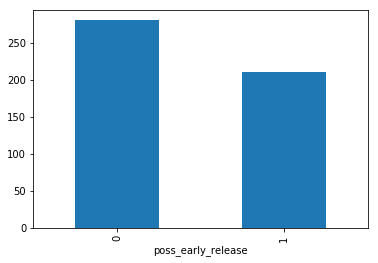

In [36]:
df1.groupby('poss_early_release').size().plot.bar()

### Problem2: Identify the discrepancy between speech sentiment score and QA sentiment score and try to find whether the returns are driven by speech or QA?

In [57]:
#Find whether the returns are driven by speech sentiment or QA sentiment
driving_sentiment_max = df1[['speech_sentiment_score','QA_sentiment_score']].idxmax(axis=1)
driving_sentiment_min = df1[['speech_sentiment_score','QA_sentiment_score']].idxmin(axis=1)
driving_sentiment = []
for i in range(len(df1)):
    if df1['next_day_ret%'][i] > df1['release_day_ret%'][i]:
        driving_sentiment.append(re.findall('^[^_]+(?=_)',driving_sentiment_max[i])[0])
    elif df1['next_day_ret%'][i] < df1['release_day_ret%'][i]:
        driving_sentiment.append(re.findall('^[^_]+(?=_)',driving_sentiment_min[i])[0])
    else:
        driving_sentiment.append('NA')
if 'Return_Driver' in df1.keys():
    df1['Return_Driver'] = driving_sentiment
else:
    df1.insert(18,'Return_Driver',driving_sentiment)

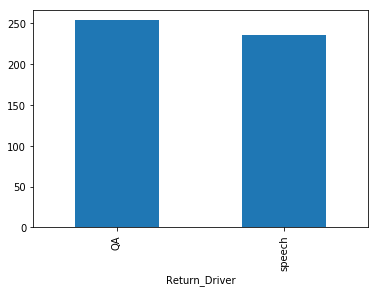

In [58]:
df1.groupby('Return_Driver').size().plot.bar()

## Data Visualization

In [59]:
def getWordsBasedOnFilter(df,ticker_name, quarter = ""):
    
    speech_list = []
    q_and_a_list = []
    
    if ticker_name != "" and quarter != "":  #filter by ticker_name and quarter
        speech_list = df[(df["ticker"]==ticker_name) & (df["qtr_year"]==quarter)]['speech']
        q_and_a_list = df[(df["ticker"]==ticker_name) & (df["qtr_year"]==quarter)]['Q_and_A']
      
        
    elif ticker_name != "" and quarter == "":   #filter by ticker_name
        speech_list = df[(df["ticker"]==ticker_name)]['speech']
        q_and_a_list = df[(df["ticker"]==ticker_name)]['Q_and_A']
        
    elif ticker_name == "" and quarter != "":    #filter by quarter
        speech_list = df[(df["qtr_year"]==quarter)]['speech']
        q_and_a_list = df[(df["qtr_year"]==quarter)]['Q_and_A']
        
    else:
        print("Please provide one or more value to filter the data")
        
    speech = ''
    q_and_a = ''
    if len(speech_list) != 0:
        speech = "".join([str(x) for x in speech_list])
        
        
    if len(q_and_a_list) != 0:
        q_and_a = "".join([str(x) for x in q_and_a_list])
       
    return speech,q_and_a

def clean_text(text):
    text = text.lower()   # lower text
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    text = tokenizer.tokenize(text)
    text = [word for word in text if not any(c.isdigit() for c in word)]  # remove words that contain numbers
    stop = nltk.corpus.stopwords.words('english')
    stop=set(stop)
    
    text = [x for x in text if x not in stop]#remove english stop words and words which appear frequently like shirts
    
    text = [t for t in text if len(t) > 2]
    
    return text

def createWordCloud(words,title,max_words=200):
    wc = WordCloud(background_color = 'white', max_font_size = 50, max_words =max_words,contour_width=3,contour_color='firebrick')
    wc.generate(str(words))
    plt.figure(figsize =[10,10])
    plt.imshow(wc, interpolation="bilinear", aspect="equal")
    plt.axis("off")
    plt.title(title, fontsize = 20)
    plt.show()

    #wc.to_file('wordCloud'+title+'.png')
    
def get_common_words(word_list,top_num):
    common_words = []
    fdist = FreqDist(word_list)
    common_words = fdist.most_common(top_num)
    print('\n Below are the top {} common words \n {}'.format(top_num,common_words))
    fdist.plot(top_num)
    return common_words

In [60]:
def visualization(tickker):  
    #create word cloud for speech and qa
    speech_list,qa_list = getWordsBasedOnFilter(df1,tickker) 
    clean_speech_words = clean_text(speech_list)
    clean_qa_words = clean_text(qa_list)
    createWordCloud(clean_speech_words,"Speech Cloud")
    createWordCloud(clean_qa_words, "QA Cloud")
    #displays top 20 common word plot
    print("Most Common words for Speech text are:\n")
    most_common_words_speech = get_common_words(clean_speech_words,20)
    print("Most Common words for QA text are:\n")
    most_common_words_QA = get_common_words(clean_qa_words,20)
    # the dispersion_plot only words for tokenized text
    #topics=['products','quarter','new','year','revenue','service','strong']
    #print(type(most_common_words_speech))
    #dispersion_plot(clean_speech_words,most_common_words_speech[:5]) 

interact(visualization, tickker=df1.ticker.unique())

interactive(children=(Dropdown(description='tickker', options=('AAPL', 'MSFT', 'AMT', 'EMHTF', 'AMZN', 'FB', '…

<function __main__.visualization(tickker)>

### Problem3: Develop a model (Multivariate regression or other applicable ML models to predict the positive or negative returns based on sentiment score of speech and QA)

In [41]:
Cor_Columns = ["speech_sentiment_score",'prev_day_ret%',
       'release_day_ret%', 'next_day_ret%',"QA_sentiment_score","overall_sentiment"]
df3=df1.loc[:,Cor_Columns]
df3
df3['SentimentType']=(df3['overall_sentiment']=='Positive').astype(int)
df3.corr()

,speech_sentiment_score,prev_day_ret%,release_day_ret%,next_day_ret%,QA_sentiment_score,SentimentType
speech_sentiment_score,1.000000,0.068524,-0.021550,-0.013614,0.133024,0.056057
prev_day_ret%,0.068524,1.000000,-0.178151,0.105959,-0.025811,0.111847
release_day_ret%,-0.021550,-0.178151,1.000000,-0.044005,-0.003592,-0.457670
next_day_ret%,-0.013614,0.105959,-0.044005,1.000000,0.017706,0.500794
QA_sentiment_score,0.133024,-0.025811,-0.003592,0.017706,1.000000,0.070186
SentimentType,0.056057,0.111847,-0.457670,0.500794,0.070186,1.000000


#### Data Partition

In [61]:
#Split the data into 80% training and 20% testing data sets
random.shuffle(df3.values)
d_part = np.random.rand(len(df3)) < 0.8
train = df3[d_part]
test = df3[~d_part]
predictors = ["speech_sentiment_score",'prev_day_ret%', 'release_day_ret%', 'next_day_ret%',"QA_sentiment_score"]
x_train=train[predictors]
y_train=train["SentimentType"]
x_test=test[predictors]
y_test=test["SentimentType"]

### Logistic Regression --- IN PROGRESS

In [ ]:
#logit_model=sm.Logit(y_train,x_train)
#logresult=logit_model.fit(maxiter=500)
#print(logresult.summary2())

### Decision Tree Classification

In [62]:
## model Creation on train Data[Decision Tree]

clf = DecisionTreeClassifier().fit(x_train,y_train)
print('Accuracy of Decision Tree classifier: {:.2f}'
     .format(clf.score(x_train,y_train)))
## testing the accuracy on test data
print('Accuracy of Decision Tree classifier for test data: {:.2f}'
     .format(clf.score(x_test,y_test)))

Accuracy of Decision Tree classifier: 1.00
Accuracy of Decision Tree classifier for test data: 0.93


### Random Forest and Variable importance plot

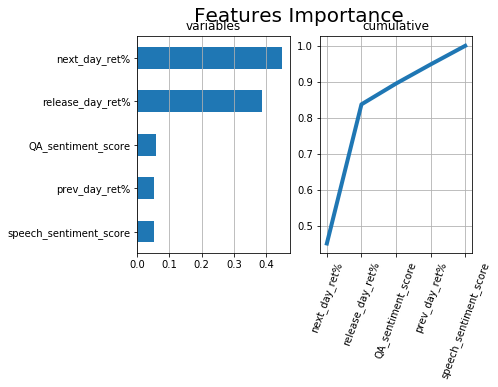

In [63]:
feature_names = x_train.columns.tolist()
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,criterion="entropy", random_state=0)
model.fit(x_train,y_train)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

### KNN

In [64]:
# Feature Scaling
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Classification using KNNClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

## Evaluating the algorithm
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[49  7]
 [ 8 40]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        56
           1       0.85      0.83      0.84        48

   micro avg       0.86      0.86      0.86       104
   macro avg       0.86      0.85      0.85       104
weighted avg       0.86      0.86      0.86       104



#### Finding best K value

Text(0, 0.5, 'Mean Error')

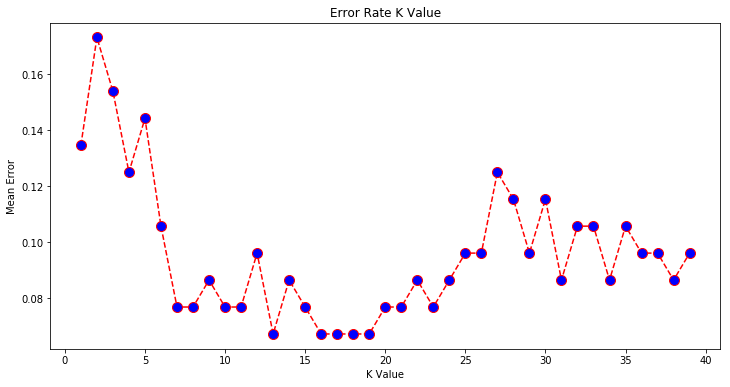

In [65]:
# Finding the best K value basis error rate
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

# plotting the k-value graph
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [68]:
### Classifying with K=13
classifier = KNeighborsClassifier(n_neighbors=13)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[52  4]
 [ 3 45]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        56
           1       0.92      0.94      0.93        48

   micro avg       0.93      0.93      0.93       104
   macro avg       0.93      0.93      0.93       104
weighted avg       0.93      0.93      0.93       104



### MVR - for predicting next_day_ret%

In [69]:
#creating a seperate dataframe for Regression analysis
mvr_columns = ["speech_sentiment_score",'prev_day_ret%',
       'release_day_ret%',"QA_sentiment_score","overall_sentiment","next_day_ret%"]
mvr=df1.loc[:,mvr_columns]
mvr['SentimentType']=(mvr['overall_sentiment']=='Positive').astype(int)
mvr.describe()

random.shuffle(mvr.values)
mvr_part = np.random.rand(len(mvr)) < 0.8
mvr_train = mvr[d_part]
mvr_test = mvr[~d_part]

## Train & Test data (80%-20%)
mvr_predictors = ["speech_sentiment_score",'prev_day_ret%', 'release_day_ret%',"QA_sentiment_score","SentimentType"]
mvrx_train=mvr_train[mvr_predictors]
mvry_train=mvr_train['next_day_ret%']
mvrx_test=mvr_test[mvr_predictors]
mvry_test=mvr_test["next_day_ret%"]

#Model
X = sm.add_constant(mvrx_train) # adding a constant
X_test = sm.add_constant(mvrx_test) 
model = sm.OLS(mvry_train, X).fit()
predictions_train = model.predict(X)
predictions_test = model.predict(X_test) 

print_model = model.summary()
print(print_model)
#print(predictions,mvry_test)

                            OLS Regression Results                            
Dep. Variable:          next_day_ret%   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     40.53
Date:                Tue, 27 Apr 2021   Prob (F-statistic):           2.24e-33
Time:                        17:06:53   Log-Likelihood:                -995.50
No. Observations:                 386   AIC:                             2003.
Df Residuals:                     380   BIC:                             2027.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2